<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_12_RF_model_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Baseline Model

1. **Set Up Baseline Model**: Load and preprocess data, set up the baseline model, and evaluate it.
2. **Tune Each Hyperparameter**:
   - Define the parameter grid for each hyperparameter.
   - Perform `GridSearchCV` to find the best parameter value.
   - Evaluate and store the results.
   - Plot the performance for each hyperparameter.
3. **Summary and Final Evaluation**: Convert the results to a DataFrame and plot the key metrics to visualize the performance of each model configuration.

This approach helps you understand the impact of each hyperparameter on the model's performance and learn more about the tuning process.




















In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_model_with_probabilities(y_true, y_prob, model_name, threshold=0.25):
    """
    Evaluate the model based on probabilities and a specified threshold.

    Parameters:
    - y_true: array-like, true labels
    - y_prob: array-like, predicted probabilities
    - model_name: str, name of the model
    - threshold: float, threshold to convert probabilities to labels

    Returns:
    - dict, classification report dictionary
    """
    y_pred = (y_prob >= threshold).astype(int)
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_dict['model'] = model_name

    # Print the classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred))

    return report_dict


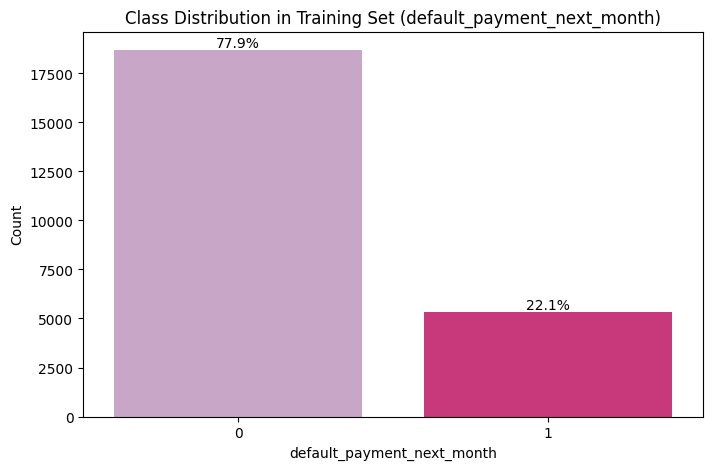

Classification Report for Baseline:

              precision    recall  f1-score   support

           0       0.93      0.25      0.39      4673
           1       0.26      0.93      0.41      1327

    accuracy                           0.40      6000
   macro avg       0.59      0.59      0.40      6000
weighted avg       0.78      0.40      0.40      6000

Results:  [{'0': {'precision': 0.9273162939297125, 'recall': 0.2484485341322491, 'f1-score': 0.39189873417721516, 'support': 4673}, '1': {'precision': 0.2603201347935973, 'recall': 0.9314242652599849, 'f1-score': 0.40691358024691354, 'support': 1327}, 'accuracy': 0.3995, 'macro avg': {'precision': 0.5938182143616548, 'recall': 0.589936399696117, 'f1-score': 0.39940615721206435, 'support': 6000}, 'weighted avg': {'precision': 0.7797989767341084, 'recall': 0.3995, 'f1-score': 0.3952195176329634, 'support': 6000}, 'model': 'Baseline'}]


In [2]:
# Import necessary functions and scripts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from data_utils import (
    preprocess_data, split_data, plot_class_distribution,
    create_preprocessing_pipeline
)

# Define your parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'
optimal_threshold = 0.25

# Load and Preprocess Data
data = preprocess_data(url, categorical_columns)
if data is not None:
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
    plot_class_distribution(y_train, target)
else:
    print("Data preprocessing failed. Please check the URL and preprocessing steps.")

# Create preprocessing steps directly within the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# New function to evaluate and store results
def evaluate_and_store_results_with_probabilities(pipeline, X_test, y_test, model_name, results_list, threshold=0.25):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    report = evaluate_model_with_probabilities(y_true=y_test, y_prob=y_pred_prob, model_name=model_name, threshold=threshold)
    results_list.append(report)
    return results_list

# Initialize results list
results_list = []

# Baseline Model
baseline_model = RandomForestClassifier(random_state=42)
baseline_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler(random_state=42)),
    ('model', baseline_model)
])

# Train and evaluate the baseline model
baseline_pipeline.fit(X_train, y_train)
results_list = evaluate_and_store_results_with_probabilities(baseline_pipeline, X_test, y_test, 'Baseline', results_list, optimal_threshold)

print("Results: ", results_list)


#### Define Plotting Function

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_hyperparameter_results(grid_search, param_name, title):
    """
    Plots the results for a given hyperparameter and highlights the best value.

    Parameters:
    - grid_search: GridSearchCV object that has been fitted to the data
    - param_name: str, name of the hyperparameter to plot
    - title: str, title of the plot
    """
    # Extract the best parameter value
    best_param = grid_search.best_params_[param_name]
    print(f"Best {param_name}: {best_param}")

    # Plot the results for the hyperparameter
    results = pd.DataFrame(grid_search.cv_results_)
    sns.set_style('ticks')
    sns.set_context('notebook')
    plt.figure(figsize=(9, 5))
    sns.lineplot(x=f'param_{param_name}', y='mean_test_score', data=results, color='orchid', linewidth=6)
    plt.axvline(x=best_param, linestyle='--', color='grey', label=f'Best {param_name}: {best_param}')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('F1 Macro Score')
    plt.legend()
    plt.show()

# def plot_n_estimators_results(grid_search):
#     """
#     Plots the results for n_estimators and highlights the best n_estimators value.

#     Parameters:
#     - grid_search: GridSearchCV object that has been fitted to the data
#     """
#     # Extract the best n_estimators value
#     best_n_estimators = grid_search.best_params_['model__n_estimators']
#     print(f"Best n_estimators: {best_n_estimators}")

#     # Plot the results for n_estimators
#     n_estimators_results = pd.DataFrame(grid_search.cv_results_)
#     sns.set_style('ticks')
#     sns.set_context('notebook')
#     plt.figure(figsize=(9, 5))
#     sns.lineplot(x='param_model__n_estimators', y='mean_test_score', data=n_estimators_results, color='orchid', linewidth=6)
#     plt.axvline(x=best_n_estimators, linestyle='--', color='grey', label=f'Best n_estimators: {best_n_estimators}')
#     plt.title('F1 Macro Score vs. Number of Estimators')
#     plt.xlabel('Number of Estimators')
#     plt.ylabel('F1 Macro Score')
#     plt.legend()
#     plt.show()

### Tune `n_estimators`

#### `n_estimators` in RandomForestClassifier

**Definition**:
- `n_estimators` is a hyperparameter in the `RandomForestClassifier` that specifies the number of trees in the forest.

**Function**:
- Each tree in the forest is trained on a random subset of the data and features.
- The final prediction is made by aggregating the predictions from all the trees, usually through majority voting for classification.

**Impact**:
- **More Trees**:
  - Generally leads to better performance by reducing variance and avoiding overfitting.
  - Increases computational cost and training time.
- **Fewer Trees**:
  - May result in a less accurate model.
  - Reduces computational cost and training time.

**Typical Use**:
- Start with a reasonable default (e.g., 100) and adjust based on model performance and available computational resources.

Classification Report for Tuned n_estimators:

              precision    recall  f1-score   support

           0       0.94      0.25      0.39      4673
           1       0.26      0.94      0.41      1327

    accuracy                           0.40      6000
   macro avg       0.60      0.59      0.40      6000
weighted avg       0.79      0.40      0.40      6000

Best model__n_estimators: 300


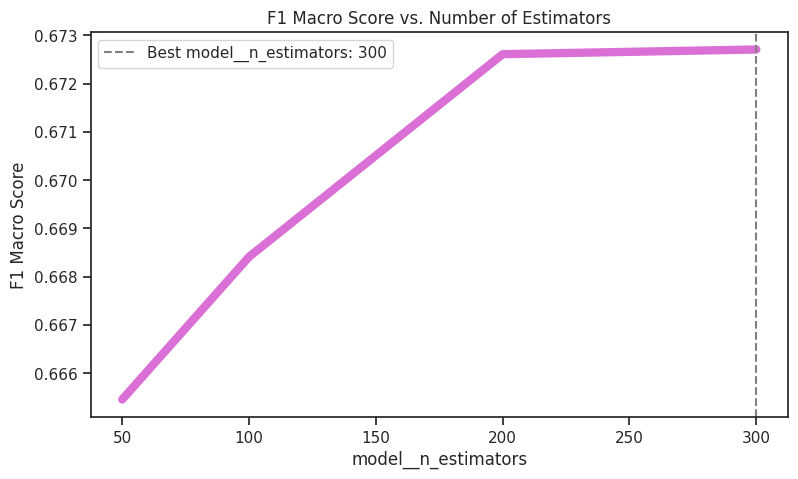

In [42]:
# Define the parameter grid for n_estimators
param_grid_n_estimators = {'model__n_estimators': [50, 100, 200, 300]}

# Perform GridSearchCV for n_estimators
grid_search_n_estimators = GridSearchCV(estimator=baseline_pipeline, param_grid=param_grid_n_estimators, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_n_estimators.fit(X_train, y_train)

# Evaluate the best model for n_estimators
best_n_estimators_model = grid_search_n_estimators.best_estimator_
results_list = evaluate_and_store_results_with_probabilities(best_n_estimators_model, X_test, y_test, 'Tuned n_estimators', results_list, optimal_threshold)
n_estimators_best_params = grid_search_n_estimators.best_params_

# Plot the results for n_estimators
plot_hyperparameter_results(grid_search_n_estimators, 'model__n_estimators', 'F1 Macro Score vs. Number of Estimators')

### Tune `max_depth`

Classification Report for Tuned max_depth:

              precision    recall  f1-score   support

           0       0.95      0.21      0.35      4673
           1       0.26      0.96      0.41      1327

    accuracy                           0.38      6000
   macro avg       0.60      0.59      0.38      6000
weighted avg       0.80      0.38      0.36      6000

Best model__max_depth: 10


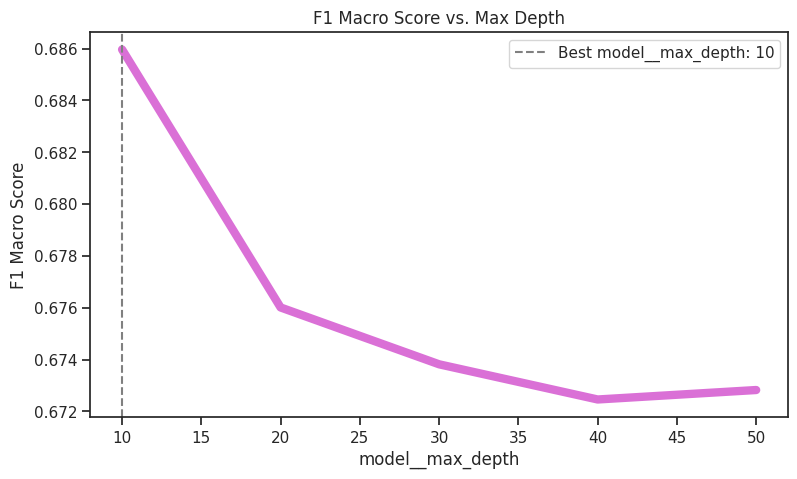

In [39]:
# Define the parameter grid for max_depth
param_grid_max_depth = {'model__max_depth': [None, 10, 20, 30, 40, 50]}

grid_search_max_depth = GridSearchCV(estimator=best_n_estimators_model, param_grid=param_grid_max_depth, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_max_depth.fit(X_train, y_train)

best_max_depth_model = grid_search_max_depth.best_estimator_
results_list = evaluate_and_store_results_with_probabilities(best_max_depth_model, X_test, y_test, 'Tuned max_depth', results_list, optimal_threshold)

max_depth_results = pd.DataFrame(grid_search_max_depth.cv_results_)
max_depth_best_params = grid_search_max_depth.best_params_

# plot results
plot_hyperparameter_results(grid_search_max_depth, 'model__max_depth', 'F1 Macro Score vs. Max Depth')

### Tune `min_samples_split`

Classification Report for Tuned min_samples_split:

              precision    recall  f1-score   support

           0       0.94      0.20      0.33      4673
           1       0.25      0.96      0.40      1327

    accuracy                           0.37      6000
   macro avg       0.60      0.58      0.37      6000
weighted avg       0.79      0.37      0.35      6000

Best model__min_samples_split: 20


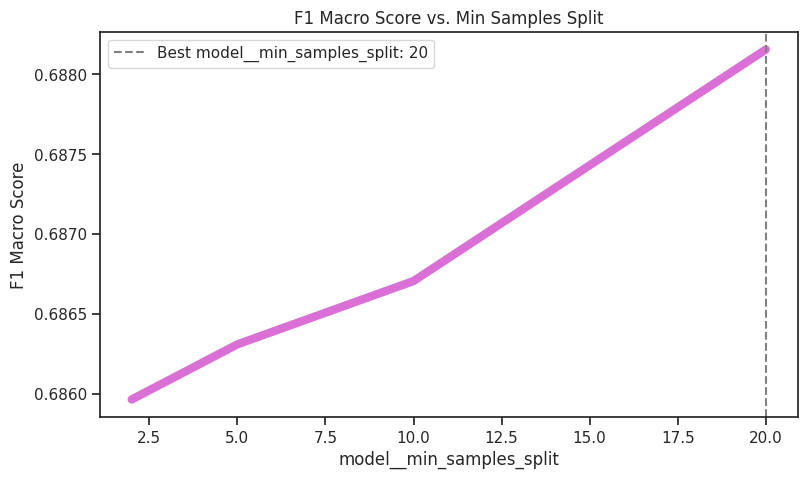

In [41]:
# Define the parameter grid for min_samples_split
param_grid_min_samples_split = {'model__min_samples_split': [2, 5, 10, 20]}

# Perform GridSearchCV for min_samples_split
grid_search_min_samples_split = GridSearchCV(estimator=best_max_depth_model, param_grid=param_grid_min_samples_split, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_min_samples_split.fit(X_train, y_train)

# Evaluate the best model for min_samples_split
best_min_samples_split_model = grid_search_min_samples_split.best_estimator_
results_list = evaluate_and_store_results_with_probabilities(best_min_samples_split_model, X_test, y_test, 'Tuned min_samples_split', results_list, optimal_threshold)
min_samples_split_best_params = grid_search_min_samples_split.best_params_

# Plot the results for min_samples_split
plot_hyperparameter_results(grid_search_min_samples_split, 'model__min_samples_split', 'F1 Macro Score vs. Min Samples Split')

### Tune `min_samples_leaf`

Classification Report for Tuned min_samples_leaf:

              precision    recall  f1-score   support

           0       0.94      0.20      0.33      4673
           1       0.25      0.96      0.40      1327

    accuracy                           0.37      6000
   macro avg       0.60      0.58      0.37      6000
weighted avg       0.79      0.37      0.35      6000

Best model__min_samples_leaf: 1


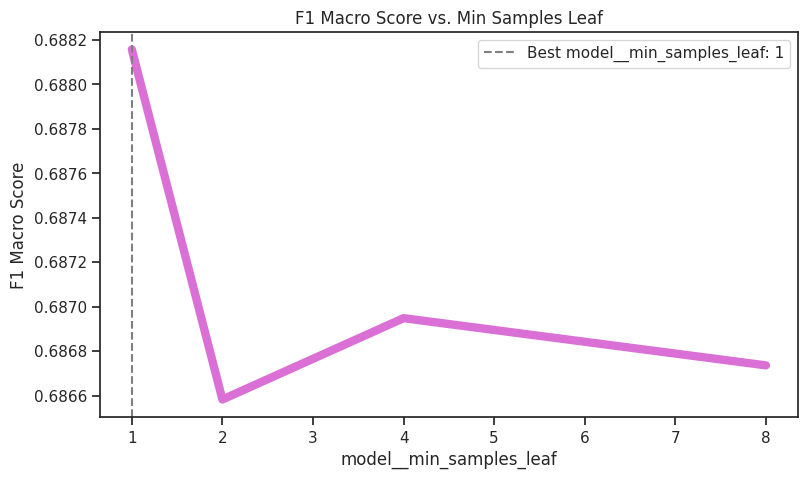

In [40]:
# Define the parameter grid for min_samples_leaf
param_grid_min_samples_leaf = {'model__min_samples_leaf': [1, 2, 4, 8]}

# Perform GridSearchCV for min_samples_leaf
grid_search_min_samples_leaf = GridSearchCV(estimator=best_min_samples_split_model, param_grid=param_grid_min_samples_leaf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_min_samples_leaf.fit(X_train, y_train)

# Evaluate the best model for min_samples_leaf
best_min_samples_leaf_model = grid_search_min_samples_leaf.best_estimator_
results_list = evaluate_and_store_results_with_probabilities(best_min_samples_leaf_model, X_test, y_test, 'Tuned min_samples_leaf', results_list, optimal_threshold)
min_samples_leaf_best_params = grid_search_min_samples_leaf.best_params_

# Plot the results for min_samples_leaf
plot_hyperparameter_results(grid_search_min_samples_leaf, 'model__min_samples_leaf', 'F1 Macro Score vs. Min Samples Leaf')

### Save Best Params

In [43]:
import json

# Store all best parameters in a dictionary
best_params_dict = {
    "n_estimators_best_params": n_estimators_best_params,
    "max_depth_best_params": max_depth_best_params,
    "min_samples_split_best_params": min_samples_split_best_params,
    "min_samples_leaf_best_params": min_samples_leaf_best_params,
    "optimal_threshold": optimal_threshold
}

# Save the best parameters to a JSON file
with open('best_params.json', 'w') as file:
    json.dump(best_params_dict, file, indent=4)

print("Best parameters saved to best_params.json")

Best parameters saved to best_params.json


In [44]:
# Load the best parameters from the JSON file
with open('best_params.json', 'r') as file:
    best_params_dict = json.load(file)

print("Loaded Best Parameters: ", best_params_dict)

Loaded Best Parameters:  {'n_estimators_best_params': {'model__n_estimators': 300}, 'max_depth_best_params': {'model__max_depth': 10}, 'min_samples_split_best_params': {'model__min_samples_split': 20}, 'min_samples_leaf_best_params': {'model__min_samples_leaf': 1}, 'optimal_threshold': 0.25}


### Train & Evaluate Tuned Model


In [45]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Extract parameters
final_params = {
    'n_estimators': best_params_dict['n_estimators_best_params']['model__n_estimators'],
    'max_depth': best_params_dict['max_depth_best_params']['model__max_depth'],
    'min_samples_split': best_params_dict['min_samples_split_best_params']['model__min_samples_split'],
    'min_samples_leaf': best_params_dict['min_samples_leaf_best_params']['model__min_samples_leaf'],
    'random_state': 42
}

# Initialize the final model
final_model = RandomForestClassifier(**final_params)

# Create the final pipeline
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler(random_state=42)),
    ('model', final_model)
])

# Train the final model
final_pipeline.fit(X_train, y_train)

# Evaluate the final model
y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= best_params_dict['optimal_threshold']).astype(int)

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.20      0.33      4673
           1       0.25      0.96      0.40      1327

    accuracy                           0.37      6000
   macro avg       0.60      0.58      0.37      6000
weighted avg       0.79      0.37      0.35      6000



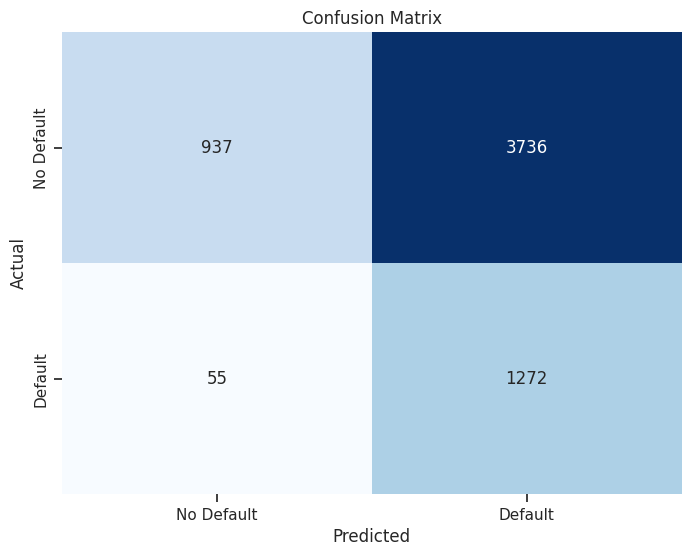

In [46]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

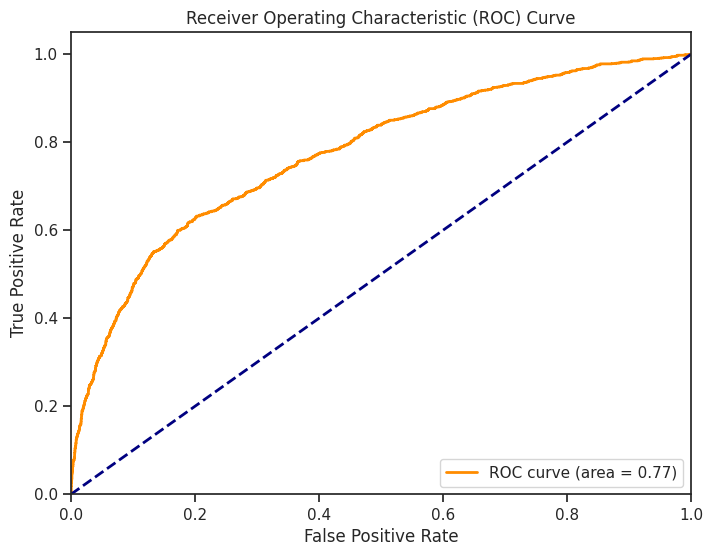

In [47]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


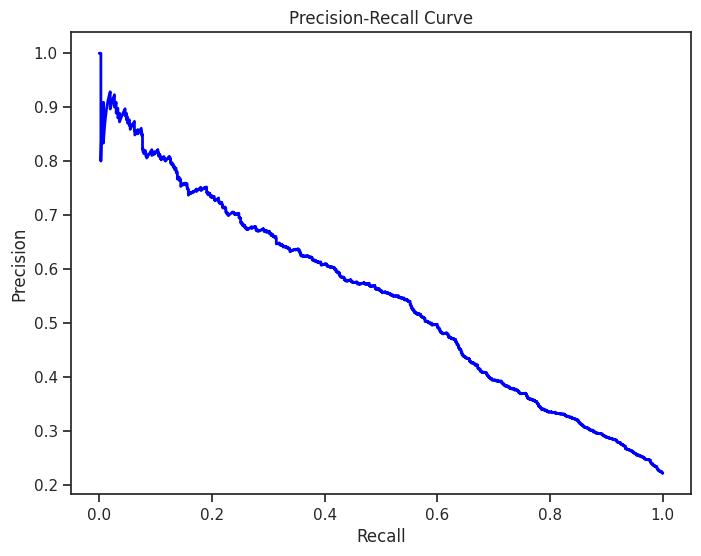

In [48]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


#### Write Data Utils Script

In [1]:
script_content = r'''
# data_utils.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load the dataset from a URL
def load_data_from_url(url):
    """
    Load the dataset from a specified URL.

    Parameters:
    - url: str, URL of the dataset

    Returns:
    - pd.DataFrame, loaded dataset
    """
    try:
        df = pd.read_excel(url, header=1)
    except Exception as e:
        print(f"Error loading data from URL: {e}")
        return None
    return df

# Clean column names
def clean_column_names(df):
    """
    Clean the column names by converting to lowercase and replacing spaces with underscores.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with cleaned column names
    """
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    """
    Remove the 'id' column if it exists.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe without 'id' column
    """
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    """
    Rename specific columns based on a predefined dictionary.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with renamed columns
    """
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    """
    Convert specified columns to categorical type.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, dataframe with converted columns
    """
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    """
    Split the data into training and testing sets.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - target: str, name of the target column

    Returns:
    - tuple, (X_train, X_test, y_train, y_test)
    """
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def preprocess_data(url, categorical_columns):
    """
    Load and preprocess the data.

    Parameters:
    - url: str, URL of the dataset
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, preprocessed data
    """
    # Load the dataset
    data = load_data_from_url(url)

    if data is None:
        return None

    # Clean column names
    data = clean_column_names(data)

    # Remove the 'id' column
    data = remove_id_column(data)

    # Rename columns
    data = rename_columns(data)

    # Convert specified columns to categorical type
    data = convert_categorical(data, categorical_columns)

    return data

# Plot class balance in the training set with ratio annotations
def plot_class_distribution(y_train, target):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='PuRd')
    plt.title(f'Class Distribution in Training Set ({target})')
    plt.xlabel(target)
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)  # Turn off the legend

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

def create_preprocessing_pipeline(numeric_features, categorical_features):
    """
    Create a preprocessing pipeline for numeric and categorical features.

    Parameters:
    - numeric_features: list of str, names of numeric features
    - categorical_features: list of str, names of categorical features

    Returns:
    - sklearn.pipeline.Pipeline, the complete preprocessing pipeline
    """
    # Define the transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine the transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Create the full pipeline with preprocessing and a placeholder for the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
        # You can add your model here, e.g., ('model', RandomForestClassifier())
    ])

    print("Preprocessing pipeline created successfully.")
    return pipeline

def add_model_to_pipeline(pipeline, model):
    """
    Add a model to the preprocessing pipeline.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the preprocessing pipeline
    - model: sklearn estimator, the model to add to the pipeline

    Returns:
    - sklearn.pipeline.Pipeline, the complete pipeline with the model added
    """
    return Pipeline(steps=pipeline.steps + [('model', model)])

def evaluate_model(pipeline, X_test, y_test, model_name):
    """
    Evaluate the model using the test data.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - X_test: pd.DataFrame or np.ndarray, the test features
    - y_test: pd.Series or np.ndarray, the test labels
    - model_name: str, name of the model

    Returns:
    - dict, the classification report with the model name included
    """
    y_pred = pipeline.predict(X_test)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_dict['model'] = model_name
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    return report_dict

def hyperparameter_tuning(pipeline, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - param_grid: dict, the parameter grid for GridSearchCV
    - X_train: pd.DataFrame or np.ndarray, the training features
    - y_train: pd.Series or np.ndarray, the training labels

    Returns:
    - sklearn estimator, the best estimator found by GridSearchCV
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters:\n", grid_search.best_params_)
    return grid_search.best_estimator_

def create_weighted_model(model_type, class_weight='balanced', random_state=42):
    """
    Create a model with class weights.

    Parameters:
    - model_type: str, type of the model ('logistic_regression' or 'random_forest')
    - class_weight: dict or 'balanced', class weights
    - random_state: int, random state for reproducibility

    Returns:
    - sklearn estimator, the model with class weights
    """
    if model_type == 'logistic_regression':
        model = LogisticRegression(class_weight=class_weight, max_iter=500, random_state=random_state)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(class_weight=class_weight, random_state=random_state)
    else:
        raise ValueError("Unsupported model type. Use 'logistic_regression' or 'random_forest'.")

    return model

'''

# Write the script to a file
with open("data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_utils.py")

# Reload script to make functions available for use
import importlib
import data_utils
importlib.reload(data_utils)

from data_utils import (load_data_from_url, clean_column_names, remove_id_column,
                        rename_columns, convert_categorical, preprocess_data, split_data, plot_class_distribution,
                        create_preprocessing_pipeline, add_model_to_pipeline, evaluate_model,
                        hyperparameter_tuning, create_weighted_model)


Script successfully written to data_utils.py


#### Write Resampling Utils Script

In [2]:
script_content = r'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate the model and return the classification report as a dictionary.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - model_name: str, name of the model

    Returns:
    - dict, classification report dictionary
    """
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    # Print the classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred))

    # Add model name to the dictionary
    report_dict['model'] = model_name

    return report_dict

def aggregate_reports(reports_list, new_report):
    """
    Aggregate classification reports into a list.

    Parameters:
    - reports_list: list, list of classification reports
    - new_report: dict, new classification report to add

    Returns:
    - list, updated list of classification reports
    """
    reports_list.append(new_report)
    return reports_list

def extract_key_metrics(reports_list, metrics, classes):
    """
    Extract key metrics from the aggregated classification reports.

    Parameters:
    - reports_list: list, list of classification reports
    - metrics: list of str, metrics to extract
    - classes: list of str, classes to include in the comparison

    Returns:
    - pd.DataFrame, DataFrame with the selected metrics
    """
    extracted_metrics = []

    for report in reports_list:
        model_name = report['model']
        for cls in classes:
            for metric in metrics:
                metric_value = report[cls][metric]
                extracted_metrics.append({
                    'model': model_name,
                    'class': cls,
                    'metric': metric,
                    'value': metric_value
                })

    return pd.DataFrame(extracted_metrics)

def plot_key_metrics(metrics_df, metrics, classes):
    """
    Plot key metrics from the aggregated classification reports.

    Parameters:
    - metrics_df: pd.DataFrame, DataFrame containing the extracted metrics
    - metrics: list of str, metrics to plot (e.g., ['recall', 'f1-score'])
    - classes: list of str, classes to include in the plot

    Returns:
    - None
    """
    primary_metric = metrics[0]
    secondary_metric = metrics[1] if len(metrics) > 1 else None

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Filter the DataFrame for the current metric
        metric_df = metrics_df[metrics_df['metric'] == metric]

        # Plot the bar plot
        sns.barplot(data=metric_df, x='model', y='value', hue='class', palette='ocean')
        plt.title(f'Comparison of {metric.capitalize()} across Models and Classes')
        plt.xlabel('Model')
        plt.ylabel(metric.capitalize())
        plt.legend(title='Class', loc='lower right', framealpha=1.0)
        plt.xticks(rotation=45)

        # Calculate and plot the average line for the primary and secondary metrics
        if metric == primary_metric or metric == secondary_metric:
            avg_metric_value = metric_df['value'].mean()
            plt.axhline(avg_metric_value, color='0.5', linestyle='--', label=f'Average {metric.capitalize()}')
            plt.legend(loc='lower right', framealpha=1.0)

        plt.show()

def evaluate_thresholds(y_true, y_pred_prob, thresholds, model_name):
    results = []
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        results.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
    plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
    plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, and F1 Score for Different Thresholds ({model_name})')
    plt.legend()
    plt.show()

    return results_df

'''

# Write the script to a file
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to resampling_utils.py")

# Reload script to make functions available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

from resampling_utils import evaluate_model, aggregate_reports, extract_key_metrics, plot_key_metrics, evaluate_thresholds


Script successfully written to resampling_utils.py
